In [1]:
# !pip install wandb

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import wandb
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import csv
%matplotlib inline

In [3]:
import pandas as pd

In [19]:
%matplotlib inline

In [5]:

plt.switch_backend('agg')

# API_KEY = 'e1e534a4439795735bad9f7d91519924c73589c7'
# wandb.login(key=API_KEY)

DECODER_ATTENTION_MODE = True
HYPERPARAMETER_TUNING_MODE_USING_WANDB = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [6]:

# pip install gdown

# import gdown
# # Google Drive file URL
# # 16yBIEtMjkb-8pmiHOk84YaLXpHrX25cW
# url = 'https://drive.google.com/uc?export=download&id=16yBIEtMjkb-8pmiHOk84YaLXpHrX25cW'
# # Path to save the downloaded file
# output_file = 'my_aksharantar_dataset_sampled.zip'
# # Download the file
# gdown.download(url, output_file, quiet=False)

# !unzip my_aksharantar_dataset_sampled.zip

TRAIN_PATH = 'processed_data/hi.translit.sampled.train.csv'
VAL_PATH = 'processed_data/hi.translit.sampled.dev.csv'
TEST_PATH = 'processed_data/hi.translit.sampled.test.csv'

MAX_LENGTH = 30

PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3:"UNK"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Function to read language data from CSV
def readLangs(lang1, lang2, data_path, reverse=False):
    '''
    function to read language data from CSV 
    '''
    print(f"Reading lines at {data_path}...")
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [l.split(',') for l in lines]
    # Reverse pairs if needed
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# Filter out pairs longer than MAX_LENGTH

def filterPair(p):
    '''
    function to filter out pairs longer than MAX_LENGTH
    '''
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    '''
    function to filter out pairs longer than MAX_LENGTH
    '''
    return [pair for pair in pairs if filterPair(pair)]

# Function to prepare data
def prepareData(lang1, lang2, data_path=TRAIN_PATH, reverse=False):
    '''
    function to prepare data
    '''
    input_lang, output_lang, pairs = readLangs(lang1, lang2, data_path, reverse)
    print(f"Read {len(pairs)} word pairs")
    print("Counting characters...")
    pairs = filterPairs(pairs)
    for pair in pairs:

        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(f"Counted characters  --  {input_lang.name}: {input_lang.n_words} -- {output_lang.name}: {output_lang.n_words}")

    return input_lang, output_lang, pairs



def indexesFromSentence(lang, sentence):
    
    
    return [lang.word2index.get(word,2)  for word in list(sentence)]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(data_path, mode='train', batch_size=32, reverse=False, input_lang=None, output_lang=None, MAX_LENGTH=MAX_LENGTH):
    if mode == 'train':
        input_lang, output_lang, pairs = prepareData('eng', 'hin', data_path, reverse=reverse)
    else:
        _, _, pairs = prepareData('eng', 'hin', data_path, reverse=reverse)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Append EOS token
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Truncate if longer than MAX_LENGTH
        if len(inp_ids) > MAX_LENGTH:
            inp_ids = inp_ids[:MAX_LENGTH]
        if len(tgt_ids) > MAX_LENGTH:
            tgt_ids = tgt_ids[:MAX_LENGTH]

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    data = TensorDataset(torch.LongTensor(input_ids).to(device),
                         torch.LongTensor(target_ids).to(device))

    sampler = RandomSampler(data) if mode == 'train' else None
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return input_lang, output_lang, dataloader



In [7]:

# ENCODER RNN
class EncoderRNN(nn.Module):
    '''
    class to define the encoder RNN
    '''
    def __init__(self, input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(input_size, hidden_size)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("rnn_type not compatible")

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded)
        return output, hidden


In [8]:

# DECODER
class DecoderRNN(nn.Module):
    '''
    class to define the decoder RNN
    '''
    def __init__(self, hidden_size, output_size, rnn_type='gru', num_layers = 1, dropout_p=0.1, bidirectional=False):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        D = 2 if bidirectional else 1
        self.out = nn.Linear(D * hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output)
        return output, hidden #ADD DROUPOUT
    


In [9]:
class ModifiedDecoderRNN(nn.Module):
    '''
    class to define the Attention Decoder RNN
    '''
    def __init__(self, hidden_size, output_size, rnn_type = 'gru',  num_layers=1, dropout_p=0.1, bidirectional=False):
        super(ModifiedDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.rnn_type = rnn_type

        if rnn_type == 'gru':
            self.rnn = nn.GRU(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        # D = 2 if bidirectional else 1
        D = 1
        self.out = nn.Linear(D * hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):

        # print(f'Attn_forward: encoder_hidden.shape: {encoder_hidden.shape}')
        # print(f'Attn_forward: encoder_outputs.shape: {encoder_outputs.shape}')
        # print(f'Attn_forward: target_tensor.shape: {target_tensor.shape}')

        batch_size = encoder_outputs.size(0)
        # print(f'Attn_forward: batch_size.shape : (batch_size.shape)')

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # print(f'Attn_forward: decoder_input.shape : {decoder_input.shape}')

        decoder_hidden = encoder_hidden
        # print(f'Attn_forward: decoder_hidden.shape : {decoder_hidden.shape}')

        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):


        # print(f'Attn_forward_step: input.shape: {input.shape}')
        # print(f'Attn_forward_step: hidden.shape: {hidden.shape}')
        # print(f'Attn_forward_step: encoder_outputs.shape: {encoder_outputs.shape}')

        embedded =  self.dropout(self.embedding(input))

        # print(f'Attn_forward_step: embedded.shape: {embedded.shape}')
        if self.rnn_type == 'lstm':
            hidden = hidden[0]

        query = hidden.permute(1, 0, 2) # a, b, c -> b, a, c
        # print(f'Attn_forward_step: query.shape {query.shape}')

        context, attn_weights = self.attention(query, encoder_outputs)

        # print(f'Attn_forward_step: context.shape {context.shape}')
        # print(f'Attn_forward_step: attn_weights.shape {attn_weights.shape}')

        input_gru = torch.cat((embedded, context), dim=2)
        # print(f'Attn_forward_step: input_gru.shape {input_gru.shape}')

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights



In [10]:

class BahdanauAttention(nn.Module):
    '''
    class to define the Bahdanau Attention
    '''
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size) # B, d -> B, d
        self.Ua = nn.Linear(hidden_size, hidden_size) # B, d -> B, d
        self.Va = nn.Linear(hidden_size, 1)# B, d -> B, 1

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys))) # 32, 1
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    '''
    class to define the Attention Decoder RNN
    '''
    def __init__(self, hidden_size, output_size, rnn_type = 'gru',  num_layers=1, dropout_p=0.1, bidirectional=False):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.rnn_type = rnn_type

        if rnn_type == 'gru':
            self.rnn = nn.GRU(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(2*hidden_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

        # D = 2 if bidirectional else 1
        D = 1
        self.out = nn.Linear(D * hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):

        # print(f'Attn_forward: encoder_hidden.shape: {encoder_hidden.shape}')
        # print(f'Attn_forward: encoder_outputs.shape: {encoder_outputs.shape}')
        # print(f'Attn_forward: target_tensor.shape: {target_tensor.shape}')

        batch_size = encoder_outputs.size(0)
        # print(f'Attn_forward: batch_size.shape : (batch_size.shape)')

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # print(f'Attn_forward: decoder_input.shape : {decoder_input.shape}')

        decoder_hidden = encoder_hidden
        # print(f'Attn_forward: decoder_hidden.shape : {decoder_hidden.shape}')

        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):


        # print(f'Attn_forward_step: input.shape: {input.shape}')
        # print(f'Attn_forward_step: hidden.shape: {hidden.shape}')
        # print(f'Attn_forward_step: encoder_outputs.shape: {encoder_outputs.shape}')

        embedded =  self.dropout(self.embedding(input))

        # print(f'Attn_forward_step: embedded.shape: {embedded.shape}')
        if self.rnn_type == 'lstm':
            hidden = hidden[0]

        query = hidden.permute(1, 0, 2) # a, b, c -> b, a, c
        # print(f'Attn_forward_step: query.shape {query.shape}')

        context, attn_weights = self.attention(query, encoder_outputs)

        # print(f'Attn_forward_step: context.shape {context.shape}')
        # print(f'Attn_forward_step: attn_weights.shape {attn_weights.shape}')

        input_gru = torch.cat((embedded, context), dim=2)
        # print(f'Attn_forward_step: input_gru.shape {input_gru.shape}')

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# class Seq2Seq(nn.Module):
#     def __init__(self, input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False):
#         super(Seq2Seq, self).__init__()
#         self.encoer_gru = gru()
#         # self.encoder = EncoderRNN(input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False)
#         # self.decoder = DecoderRNN(input_size, hidden_size,  rnn_type='gru', num_layers=1, dropout_p=0.1, bidirectional=False)

#     def encoder():
#         # Encoder forward
#         pass

#     def decoer():
#         # decoder forward
#         pass

#     def forward(self, input):
#         encoder_outputs, encoder_hidden = self.encoder(input)
#         return self.decoder(encoder_outputs, encoder_hidden, target_tensor)


In [11]:

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):    

    encoder.train()
    decoder.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    total_tokens = 0
    total_correct_words = 0
    total_words = 0

    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        if wandb.run:
            wandb.log({"train_batch_loss": loss.item()})

    #     # Calculate accuracy
    #     _, predicted = decoder_outputs.max(2)
    #     correct = predicted.eq(target_tensor)
    #     total_correct += correct.sum().item()
    #     total_samples += correct.numel()

    # accuracy = total_correct / total_samples
    # return total_loss / len(dataloader), accuracy

        # Calculate accuracy
        _, predicted = decoder_outputs.max(2)
        mask = target_tensor != PAD_token
        total_correct += (target_tensor == predicted)[mask].sum().item()
        total_tokens += mask.sum().item()
        total_correct_words += ((predicted != target_tensor).sum(1) == 0).sum().item()
        total_words += len(predicted)
        # _, predicted = decoder_outputs.max(2)
        # non_pad_mask_pred = predicted.ne(PAD_token)  # Mask for non-padded tokens in predicted sequences
        # non_pad_mask_tgt = target_tensor.ne(PAD_token)  # Mask for non-padded tokens in target sequences
        # correct_mask = predicted.eq(target_tensor) & non_pad_mask_pred & non_pad_mask_tgt
        # total_correct += correct_mask.sum().item()
        # total_tokens += non_pad_mask_tgt.sum().item()

    accuracy = total_correct / total_tokens
    total_loss = total_loss / len(dataloader)
    word_accuracy = total_correct_words / total_words
    if wandb.run:
        wandb.log({"train_token_accuracy": accuracy})
        wandb.log({"train_word_accuracy": word_accuracy})
        wandb.log({"train_loss": total_loss})
    return total_loss, word_accuracy

def val_epoch(dataloader, encoder, decoder, criterion, mode="val"):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    total_tokens = 0
    total_correct_words = 0
    total_words = 0

    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )


        total_loss += loss.item()



    #     # Calculate accuracy
    #     _, predicted = decoder_outputs.max(2)
    #     correct = predicted.eq(target_tensor)
    #     total_correct += correct.sum().item()
    #     total_samples += correct.numel()

    # accuracy = total_correct / total_samples
    # return total_loss / len(dataloader), accuracy
        # Calculate accuracy
        # Calculate accuracy
        _, predicted = decoder_outputs.max(2)
        mask = target_tensor != PAD_token
        total_correct += (target_tensor == predicted)[mask].sum().item()
        total_tokens += mask.sum().item()
        total_correct_words += ((predicted != target_tensor).sum(1) == 0).sum().item()
        total_words += len(predicted)

        # non_pad_mask_pred = predicted.ne(PAD_token)  # Mask for non-padded tokens in predicted sequences
        # non_pad_mask_tgt = target_tensor.ne(PAD_token)  # Mask for non-padded tokens in target sequences
        # correct_mask = predicted.eq(target_tensor) & non_pad_mask_pred & non_pad_mask_tgt
        # total_correct += correct_mask.sum().item()
        # total_tokens += non_pad_mask_tgt.sum().item()

    accuracy = total_correct / total_tokens
    total_loss = total_loss / len(dataloader)
    word_accuracy = total_correct_words / total_words
    if wandb.run:
        wandb.log({f"{mode}_token_accuracy": accuracy})
        wandb.log({f"{mode}_word_accuracy": word_accuracy})
        wandb.log({f"{mode}_loss": total_loss})
    return total_loss, word_accuracy



def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, val_dataloader, test_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    
    train_loss_his = []
    train_accuracy_his = []
    val_loss_his = []   
    val_accuracy_his = []

    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss, accuracy = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        train_loss_his.append(loss)
        train_accuracy_his.append(accuracy) 

        print_loss_total += loss
        plot_loss_total += loss

        val_loss, val_accuracy = val_epoch(val_dataloader, encoder, decoder, criterion, mode='val')

        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        

        print(f'Epoch: {epoch}; train_loss: {loss}; train_accuracy: {accuracy}; val_loss: {val_loss}; val_accuracy: {val_accuracy}')

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    test_loss, test_accuracy = val_epoch(test_dataloader, encoder, decoder, criterion, mode='test')

    print(f'test_loss: {test_loss}; test_accuracy: {test_accuracy}')

    showPlot(plot_losses)

    return train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy

# Plotting results



def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

# We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(pair)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

def predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['English Word', 'Hindi Word', 'Predicted Word'])

        for data in test_dataloader:
            input_tensor, target_tensor = data
            for i in range(len(input_tensor)):
                # Convert input_tensor to input_sentence without EOS
                input_sentence = ''.join([input_lang.index2word[idx.item()] for idx in input_tensor[i] if idx.item() != 0 and input_lang.index2word[idx.item()] != 'EOS'])
                # Convert target_tensor to target_sentence without EOS
                target_sentence = ''.join([output_lang.index2word[idx.item()] for idx in target_tensor[i] if idx.item() != 0 and output_lang.index2word[idx.item()] != 'EOS'])
                # Get the predicted words
                output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
                # Exclude <EOS> and <PAD> tokens from predicted words
                predicted_word = ''.join([word for word in output_words if word not in ('EOS', 'PAD', '<EOS>')])
                # Write the results to CSV file
                writer.writerow([input_sentence, target_sentence, predicted_word])

    print(f"Predictions saved to {output_file}")

def get_example_from_csv(csv_file, index):
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        examples = list(reader)

    if index < len(examples):
        input_sentence, target_sentence = examples[index]
        return input_sentence, target_sentence
    else:
        print("Index out of range.")
        return None, None

TTF_PATH = '/mnt/media/guest1/abhijeet/assignments/deep_learning/assignment_03/attention_seq_to_seq/aksharantar_sampled/hin/Nirmala.ttf'
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname=TTF_PATH, size=12)


def showAttention(input_sentence, target_sentence, output_words, attentions, ax):
    
    
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax, ax=ax)

    # Set up axes
    ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
    ax.set_yticklabels([''] + output_words, fontproperties=font_prop)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

def evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('Input:', input_sentence)
    print('Target:', target_sentence)
    print('Predicted Output:', ''.join(output_words))
    showAttention(input_sentence, target_sentence, output_words, attentions[0, :len(output_words), :], ax)



In [12]:
import matplotlib.pyplot as plt

def plot_training_results(train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, test_loss, test_accuracy):
    epochs = range(1, len(train_loss_history) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, 'b', label='Training loss')
    plt.plot(epochs, val_loss_history, 'r', label='Validation loss')
    plt.scatter(len(epochs), test_loss, c='g', label='Test loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_history, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy_history, 'r', label='Validation accuracy')
    plt.scatter(len(epochs), test_accuracy, c='g', label='Test accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [13]:
# Training with best hyperparameter for vanilla seq to seq  mode config:
HIDDEN_SIZE = 64
BATCH_SIZE = 128
NUM_LAYERS_ENCODER = 3
NUM_LAYERS_DECODER = 3
N_EPOCHS = 50
RNN_TYPE_ENCODER = 'lstm'
RNN_TYPE_DECODER = 'lstm'
DROUPOUT = 0.1
BIDIRECTIONAL = False
BEAM_SEARCH_SIZE = 1
LEARNING_RATE = 0.001


# Get dataloaders
input_lang, output_lang, train_dataloader = get_dataloader(data_path=TRAIN_PATH, mode='train', batch_size=BATCH_SIZE, reverse=False)
_, _, val_dataloader = get_dataloader(data_path=VAL_PATH, mode='val', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)
_, _, test_dataloader = get_dataloader(data_path=TEST_PATH, mode='test', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)


encoder = EncoderRNN(input_lang.n_words, rnn_type=RNN_TYPE_ENCODER, hidden_size = HIDDEN_SIZE, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)
decoder = DecoderRNN(hidden_size = HIDDEN_SIZE, output_size = output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers = NUM_LAYERS_ENCODER, dropout_p = DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)

# with wandb.init(project="MCV_ASSIGNMENT01_PART_03", entity="abhijeet001"):


print(f'-----------------------TRAINING : VANILLA S2S MODE----------------------------')

train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy = train(
                                                                                                        train_dataloader,
                                                                                                        val_dataloader,
                                                                                                        test_dataloader,
                                                                                                        encoder,
                                                                                                        decoder,
                                                                                                        n_epochs=N_EPOCHS,
                                                                                                        learning_rate=LEARNING_RATE,
                                                                                                        print_every=5, plot_every=5
                                                                                                    )



Reading lines at processed_data/hi.translit.sampled.train.csv...
Read 44204 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 67
Reading lines at processed_data/hi.translit.sampled.dev.csv...
Read 4358 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
Reading lines at processed_data/hi.translit.sampled.test.csv...
Read 4502 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
-----------------------TRAINING : VANILLA S2S MODE----------------------------


/home/guest1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1; train_loss: 1.027219657780807; train_accuracy: 0.0; val_loss: 0.7137132831982204; val_accuracy: 0.0
Epoch: 2; train_loss: 0.69818470605536; train_accuracy: 4.52447742285766e-05; val_loss: 0.6320064578737531; val_accuracy: 0.0
Epoch: 3; train_loss: 0.6195468404734066; train_accuracy: 0.0003167134196000362; val_loss: 0.5672985655920846; val_accuracy: 0.0002294630564479119
Epoch: 4; train_loss: 0.5552473853778288; train_accuracy: 0.0012668536784001447; val_loss: 0.5014563798904419; val_accuracy: 0.0009178522257916476
Epoch: 5; train_loss: 0.4789991870608633; train_accuracy: 0.005904443036829246; val_loss: 0.4225120399679456; val_accuracy: 0.013538320330426802
0m 59s (- 8m 53s) (5 10%) 0.6758
Epoch: 6; train_loss: 0.40918258719706124; train_accuracy: 0.020586372274002354; val_loss: 0.36200221010616845; val_accuracy: 0.026847177604405692
Epoch: 7; train_loss: 0.3522885345310145; train_accuracy: 0.042235996742376256; val_loss: 0.3149762898683548; val_accuracy: 0.04841670491050941
E

<Figure size 640x480 with 0 Axes>

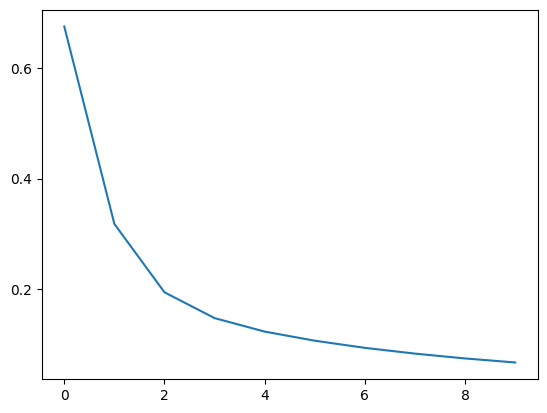

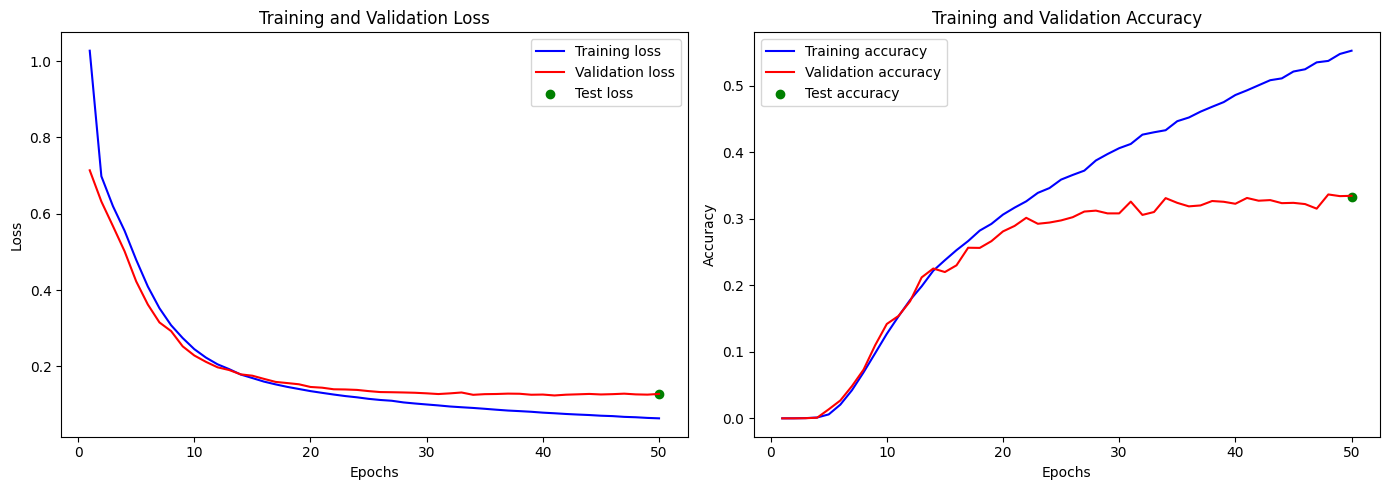

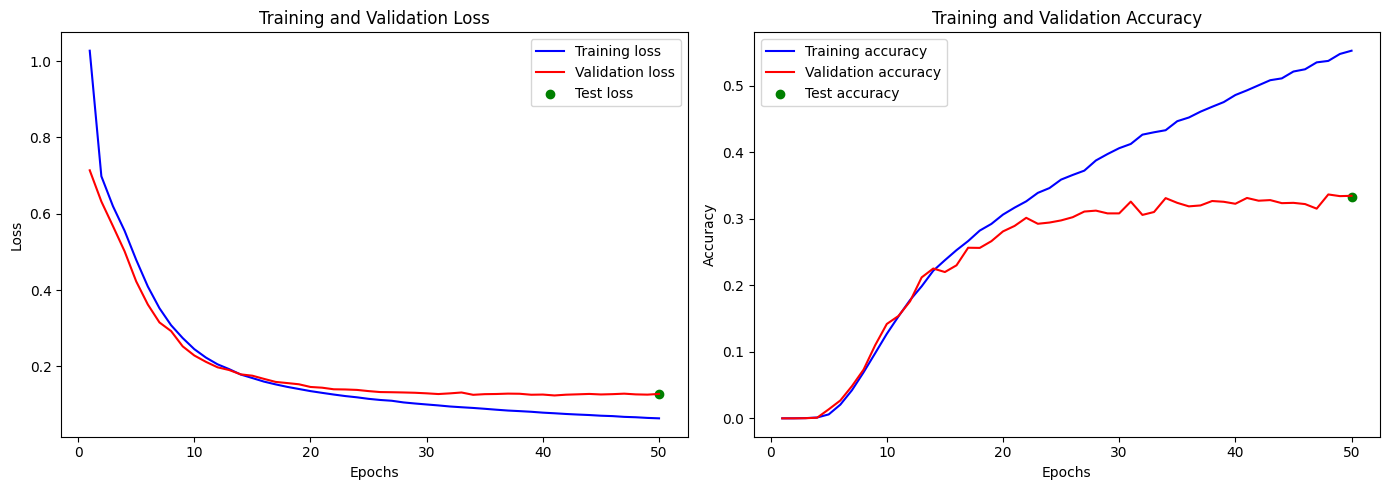

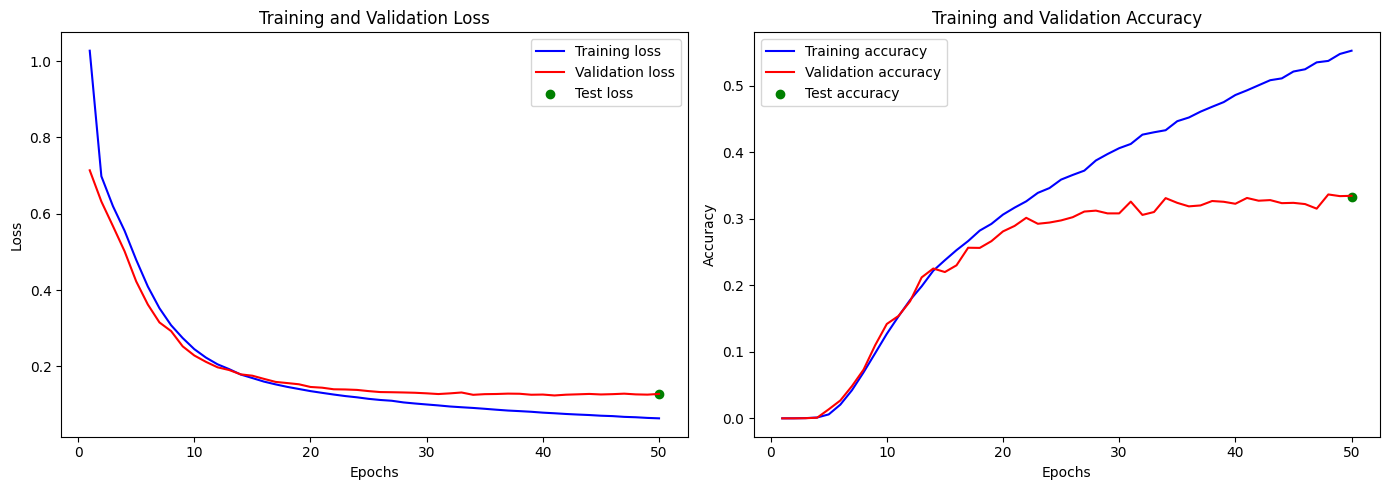

In [20]:
%matplotlib inline
plot_training_results(train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy)


In [15]:
import csv
# Replace 'output_file_path.csv' with the path where you want to save the predictions
output_file_path = f'vanilla_s2s_predictions.csv'
predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file_path)
print("Predictions saved in", output_file_path)

Predictions saved to vanilla_s2s_predictions.csv
Predictions saved in vanilla_s2s_predictions.csv


In [16]:
test_prediction_vanilla = pd.read_csv('vanilla_s2s_predictions.csv')
test_prediction_vanilla.head(5)

,English Word,Hindi Word,Predicted Word
0,ank,अंक,ऩ
1,anka,अंक,ऩारा
2,ankit,अंकित,नकर
3,anakon,अंकों,नावों
4,ankhon,अंकों,नकों


Reading lines at processed_data/hi.translit.sampled.train.csv...
Read 44204 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 67
Reading lines at processed_data/hi.translit.sampled.dev.csv...
Read 4358 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
Reading lines at processed_data/hi.translit.sampled.test.csv...
Read 4502 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
-------------------------TRAINING : ATTENTION MODE------------------------------
Epoch: 1; train_loss: 0.8897557339885018; train_accuracy: 0.0; val_loss: 0.6331092596054078; val_accuracy: 0.0
Epoch: 2; train_loss: 0.576693095266819; train_accuracy: 0.0010858745814858383; val_loss: 0.45672873854637147; val_accuracy: 0.006424965580541533
Epoch: 3; train_loss: 0.38470874320377; train_accuracy: 0.02911501221608904; val_loss: 0.2692787885665894; val_accuracy: 0.08054153281321708
Epoch: 4; train_loss: 0.2276620478792624; train_accuracy: 0.1415708

<Figure size 640x480 with 0 Axes>

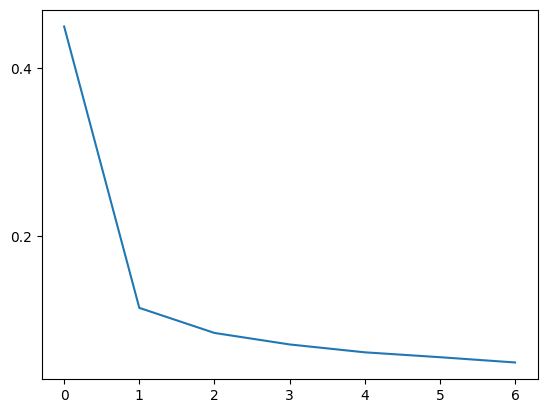

In [22]:
# Training with best hyperparameter for attention mode config:
HIDDEN_SIZE = 128
BATCH_SIZE = 1024
NUM_LAYERS_ENCODER = 1
NUM_LAYERS_DECODER = 1
N_EPOCHS = 35
RNN_TYPE_ENCODER = 'gru'
RNN_TYPE_DECODER = 'gru'
DROUPOUT = 0.1
BIDIRECTIONAL = False
BEAM_SEARCH_SIZE = 1
LEARNING_RATE = 0.005



# Get dataloaders
input_lang, output_lang, train_dataloader = get_dataloader(data_path=TRAIN_PATH, mode='train', batch_size=BATCH_SIZE, reverse=False)
_, _, val_dataloader = get_dataloader(data_path=VAL_PATH, mode='val', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)
_, _, test_dataloader = get_dataloader(data_path=TEST_PATH, mode='test', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)

encoder = EncoderRNN(input_lang.n_words, rnn_type=RNN_TYPE_ENCODER, hidden_size = HIDDEN_SIZE, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)
decoder = AttnDecoderRNN(hidden_size = HIDDEN_SIZE, output_size = output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)

print(f'-------------------------TRAINING : ATTENTION MODE------------------------------')

train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy = train(
                                                                                                        train_dataloader,
                                                                                                        val_dataloader,
                                                                                                        test_dataloader,
                                                                                                        encoder,
                                                                                                        decoder,
                                                                                                        n_epochs=N_EPOCHS,
                                                                                                        learning_rate=LEARNING_RATE,
                                                                                                        print_every=5, plot_every=5
                                                                                                    )



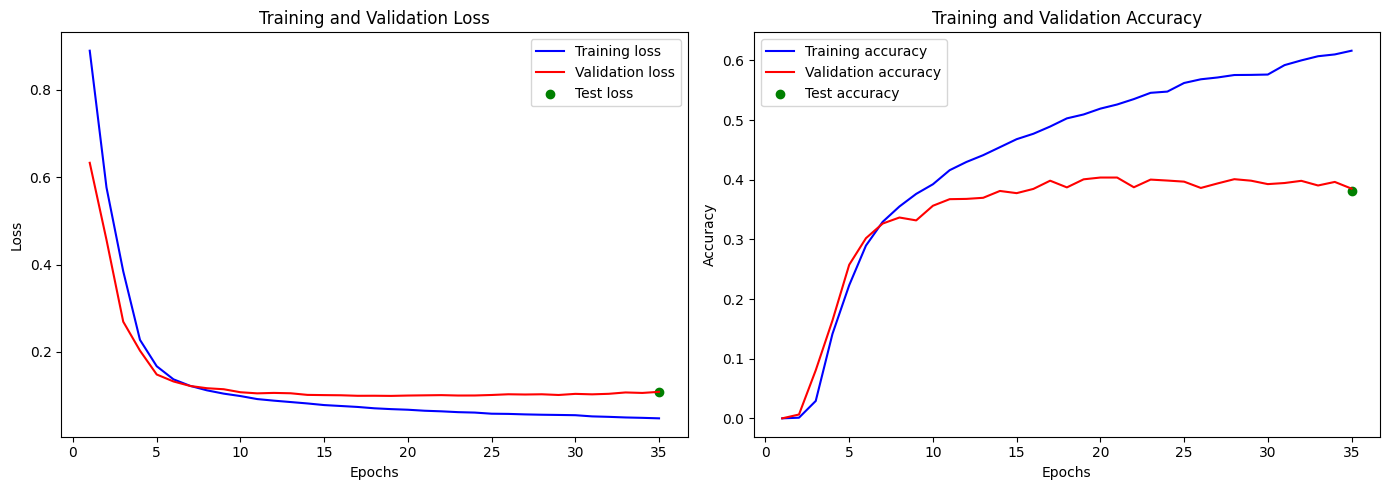

In [23]:
%matplotlib inline
plot_training_results(train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy)


In [24]:
output_file_path = f'attention_s2s_predictions.csv'
predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file_path)
print("Predictions saved in", output_file_path)


Predictions saved to attention_s2s_predictions.csv
Predictions saved in attention_s2s_predictions.csv


In [25]:
test_prediction_attn = pd.read_csv('attention_s2s_predictions.csv')
test_prediction_attn.head(5)

,English Word,Hindi Word,Predicted Word
0,ank,अंक,ट
1,anka,अंक,कंका
2,ankit,अंकित,किट
3,anakon,अंकों,नकों
4,ankhon,अंकों,नखों


Reading lines at processed_data/hi.translit.sampled.train.csv...
Read 44204 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 67
Reading lines at processed_data/hi.translit.sampled.dev.csv...
Read 4358 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
Reading lines at processed_data/hi.translit.sampled.test.csv...
Read 4502 word pairs
Counting characters...
Counted characters  --  eng: 30 -- hin: 65
-------------------------TRAINING : MODIFIED DECODER MODE------------------------------
Epoch: 1; train_loss: 0.8739635294133966; train_accuracy: 0.0; val_loss: 0.6213860154151917; val_accuracy: 0.0
Epoch: 2; train_loss: 0.5586975555528294; train_accuracy: 0.0025110849696860014; val_loss: 0.4269930779933929; val_accuracy: 0.005736576411197797
Epoch: 3; train_loss: 0.3479343151504343; train_accuracy: 0.05130757397520586; val_loss: 0.23211473524570464; val_accuracy: 0.12987608994951813
Epoch: 4; train_loss: 0.2042498571628874; train_accuracy:

<Figure size 640x480 with 0 Axes>

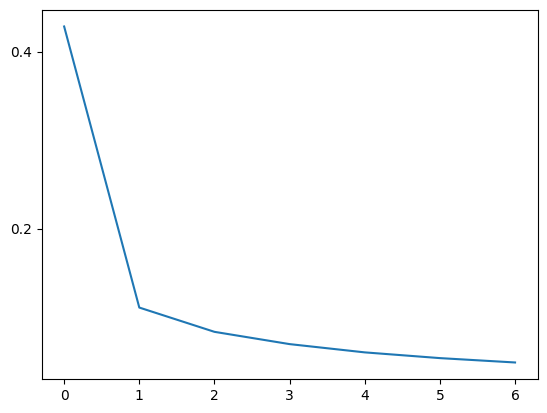

In [26]:
# Training with best hyperparameter for modified mode config:
HIDDEN_SIZE = 128
BATCH_SIZE = 1024
NUM_LAYERS_ENCODER = 1
NUM_LAYERS_DECODER = 1
N_EPOCHS = 35
RNN_TYPE_ENCODER = 'gru'
RNN_TYPE_DECODER = 'gru'
DROUPOUT = 0.1
BIDIRECTIONAL = False
BEAM_SEARCH_SIZE = 1
LEARNING_RATE = 0.005



# Get dataloaders
input_lang, output_lang, train_dataloader = get_dataloader(data_path=TRAIN_PATH, mode='train', batch_size=BATCH_SIZE, reverse=False)
_, _, val_dataloader = get_dataloader(data_path=VAL_PATH, mode='val', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)
_, _, test_dataloader = get_dataloader(data_path=TEST_PATH, mode='test', batch_size=BATCH_SIZE, reverse=False, input_lang=input_lang, output_lang=output_lang)

encoder = EncoderRNN(input_lang.n_words, rnn_type=RNN_TYPE_ENCODER, hidden_size = HIDDEN_SIZE, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)
decoder = ModifiedDecoderRNN(hidden_size = HIDDEN_SIZE, output_size = output_lang.n_words, rnn_type=RNN_TYPE_ENCODER, num_layers = NUM_LAYERS_ENCODER, dropout_p=DROUPOUT, bidirectional=BIDIRECTIONAL).to(device)

print(f'-------------------------TRAINING : MODIFIED DECODER MODE------------------------------')

train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy = train(
                                                                                                        train_dataloader,
                                                                                                        val_dataloader,
                                                                                                        test_dataloader,
                                                                                                        encoder,
                                                                                                        decoder,
                                                                                                        n_epochs=N_EPOCHS,
                                                                                                        learning_rate=LEARNING_RATE,
                                                                                                        print_every=5, plot_every=5
                                                                                                    )



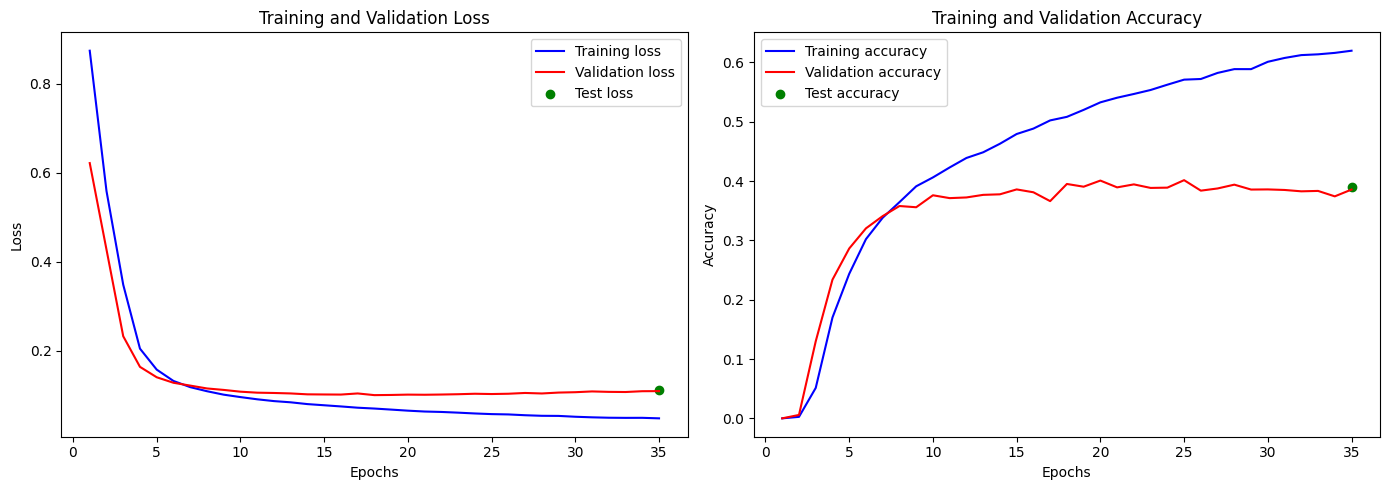

In [27]:
%matplotlib inline
plot_training_results(train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his, test_loss, test_accuracy)


In [28]:
output_file_path = f'modified_s2s_predictions.csv'
predict_and_save(input_lang, output_lang, test_dataloader, encoder, decoder, output_file_path)
print("Predictions saved in", output_file_path)


Predictions saved to modified_s2s_predictions.csv
Predictions saved in modified_s2s_predictions.csv


In [29]:
test_prediction_modified = pd.read_csv('modified_s2s_predictions.csv')
test_prediction_modified.head(5)

,English Word,Hindi Word,Predicted Word
0,ank,अंक,केंक
1,anka,अंक,काका
2,ankit,अंकित,अंकित
3,anakon,अंकों,अनकों
4,ankhon,अंकों,नक्खों


Input: ank
Target: अंक
Predicted Output: केंक<EOS>
Input: anka
Target: अंक
Predicted Output: काका<EOS>
Input: ankit
Target: अंकित
Predicted Output: अंकित<EOS>
Input: anakon
Target: अंकों
Predicted Output: अनकों<EOS>
Input: ankhon
Target: अंकों
Predicted Output: नक्खों<EOS>


/tmp/ipykernel_266636/2293200361.py:280: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:280: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproper

Input: ankon
Target: अंकों
Predicted Output: एंकों<EOS>
Input: angkor
Target: अंकोर
Predicted Output: आंगोर<EOS>
Input: ankor
Target: अंकोर
Predicted Output: कंकर<EOS>
Input: angaarak
Target: अंगारक
Predicted Output: जंगारक<EOS>


/tmp/ipykernel_266636/2293200361.py:280: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:280: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(target_sentence) + ['<EOS>'], rotation=90, fontproperties=font_prop)
/tmp/ipykernel_266636/2293200361.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words, fontproper

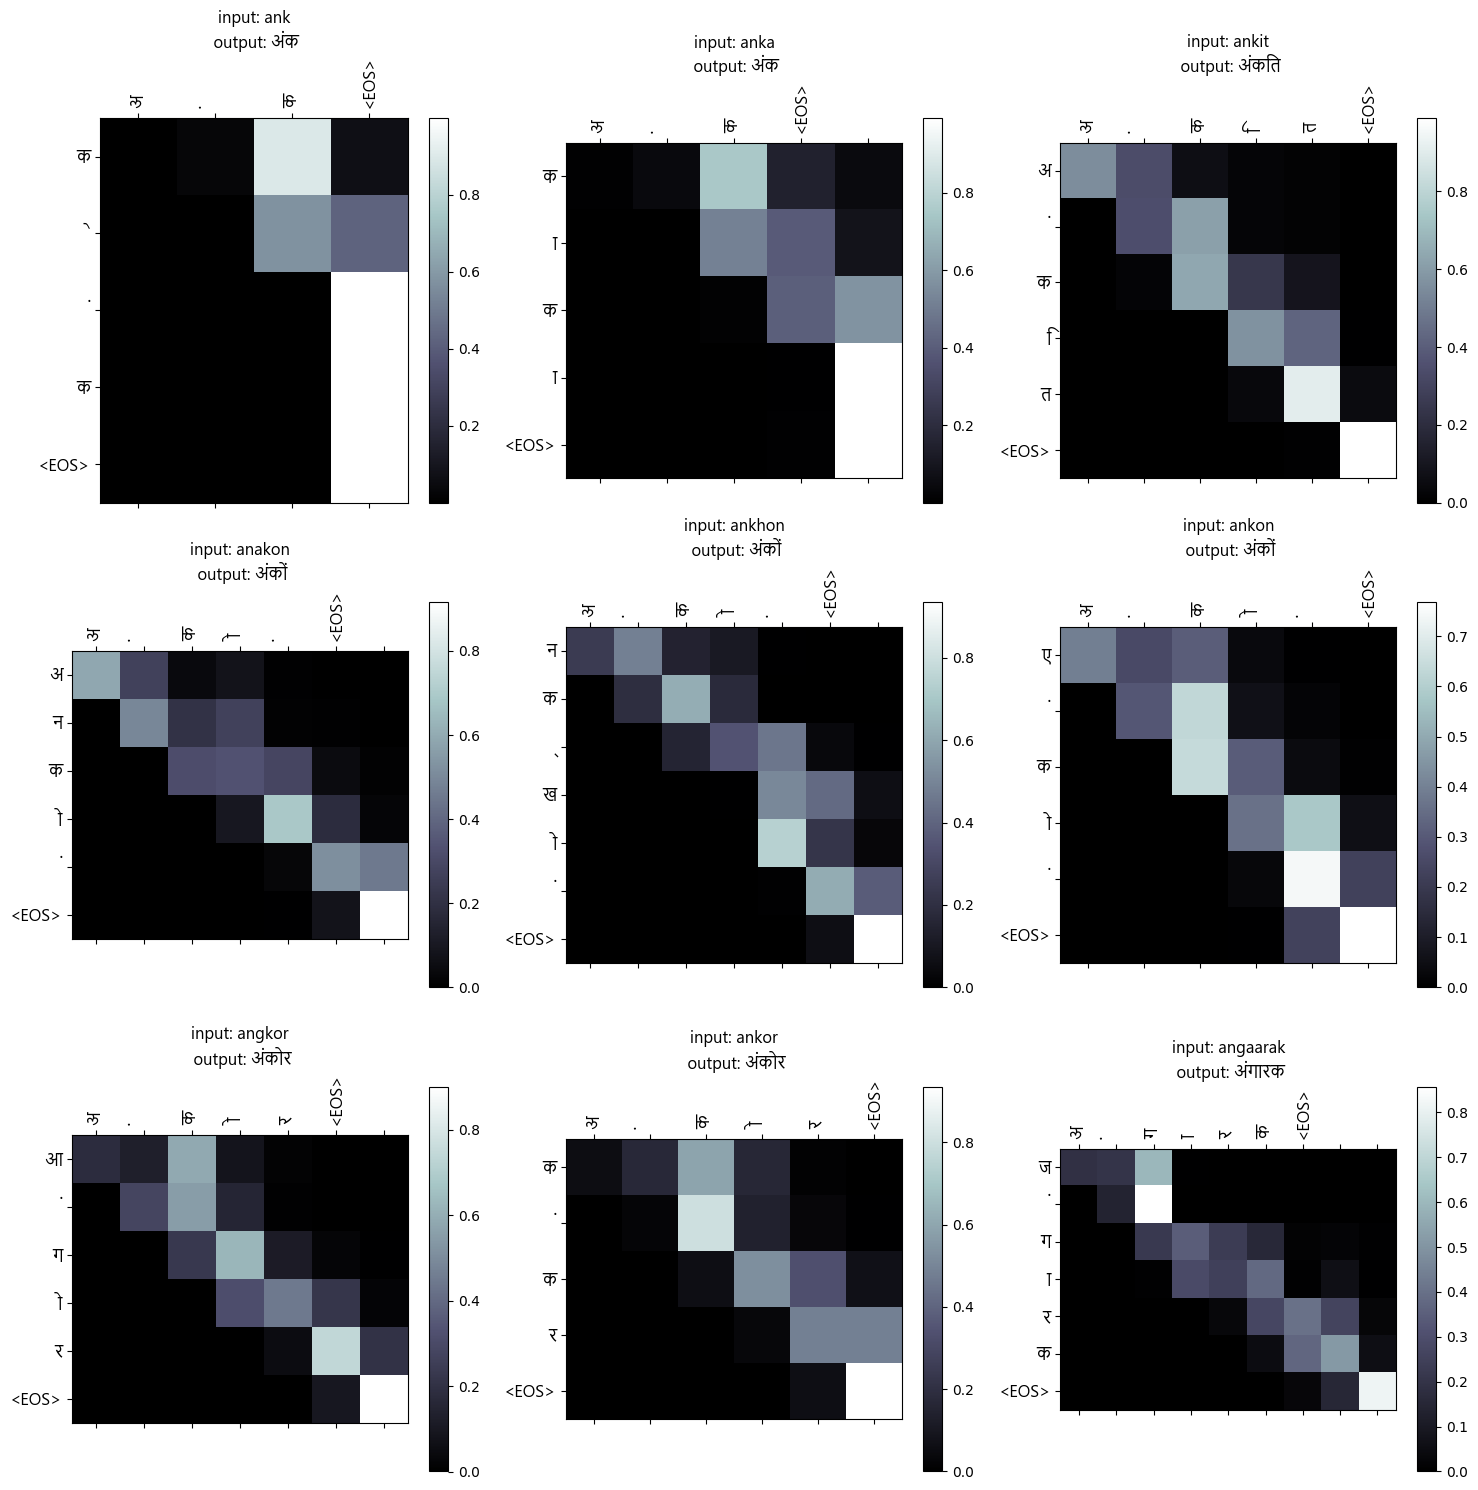

In [30]:
# Load examples from CSV
examples = []
with open(TEST_PATH, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    examples = list(reader)

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Get 10 samples and visualize attention for each
for i, ax in enumerate(axs.flat):
    if i < len(examples):
        input_sentence, target_sentence = examples[i]
        ax.set_title(f"input: {input_sentence}\n output: {target_sentence}", fontproperties=font_prop)
        evaluateAndShowAttention(input_sentence, target_sentence, encoder, decoder, input_lang, output_lang, ax)
    else:
        # If there are fewer than 10 examples, leave the subplot empty
        ax.axis('off')

plt.tight_layout()
plt.show()